## Monte Carlo Integration

In [58]:
from sympy import symbols,integrate
import numpy as np
import math
import random
from matplotlib import pyplot as plt 
from IPython.display import clear_output

In [25]:
#e,x = symbols('e x')
#eq = (e**-x)/(1 + (x-1)**2)
#eq # equation to integrate

### Crude Solution

In [33]:
PI = 3.1415926
e = 2.71828

def get_rand_number(_min,_max):
    """ generate uniform distribuition"""
    _range = _max - _min
    rand = random.uniform(0,1)
    return _min + _range*rand

def function(x):
    """function to integrate over"""
    return (e**(-1*x))/(1+(x-1)**2)


def solve_mc(num_samples = 5000, bounds = (0,5)):
    """approx integral for a specified numbers
    of samples
    bound 0 -5 is sufficient because eq approaches 0 close to PI
    """
    lower = bounds[0]
    upper = bounds[1]
    
    sum_of_samples = 0
    
    for _ in range(num_samples):
        x = get_rand_number(lower,upper)
        sum_of_samples += function(x)
        
    return (upper-lower)*float(sum_of_samples/num_samples)
    
solve_mc(num_samples=10000)

0.6722199772528376

### Determine confidence in estimation

To determine confidence we can quantify accuracy by studying the variance of the estimation

In [45]:
def crude_mc_variance(num_samples = 10000,int_max = 5):
    """returns the variance for crude mc estimate
        arg:
            int_max - max of integration range
    
    """
    
    # get the average of the squares
    total = 0
    for _ in range(num_samples):
        x = get_rand_number(0,int_max)
        total += function(x)**2
    sum_of_squares = total*int_max / num_samples
    
    # get square of the average
    total = 0
    for _ in range(num_samples):
        x = get_rand_number(0,int_max)
        total = function(x)
    sq_average = (int_max*total/num_samples)**2
    
    return sum_of_squares - sq_average

print('Variance',crude_mc_variance())


Variance 0.266019532725026


How to increase accuracy (reduce variance) without increasing the number of samples?

### Importance Sampling

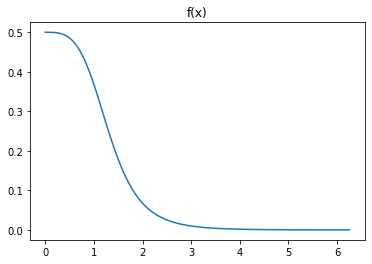

In [56]:
xs = [float(i/50) for i in range(int(50*PI*2))]
ys = [function(x) for x in xs]
plt.plot(xs,ys)
plt.title("f(x)");

We can see that the function is mostly active in the rough range of [0,3] and is mostly inactive in the range of [3,inf]. Let's see if we can find a function template that can be parameterized to replicate this quality.

In [59]:
# this is the template of our weight function g(x)
def g_of_x(x, A, lamda):
    e = 2.71828
    return A*math.pow(e, -1*lamda*x)

def inverse_G_of_r(r, lamda):
    return (-1 * math.log(float(r)))/lamda

def get_IS_variance(lamda, num_samples):
    """
    This function calculates the variance if a Monte Carlo
    using importance sampling.
    Args:
    - lamda (float) : lamdba value of g(x) being tested
    Return: 
    - Variance
    """
    A = lamda
    int_max = 5
    
    # get sum of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += (function(x)/g_of_x(x, A, lamda))**2
    
    sum_of_sqs = running_total / num_samples
    
    # get squared average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += function(x)/g_of_x(x, A, lamda)
    sq_ave = (running_total/num_samples)**2
    
    
    return sum_of_sqs - sq_ave

# get variance as a function of lambda by testing many
# different lambdas

test_lamdas = [i*0.05 for i in range(1, 61)]
variances = []

for i, lamda in enumerate(test_lamdas):
    print(f"lambda {i+1}/{len(test_lamdas)}: {lamda}")
    A = lamda
    variances.append(get_IS_variance(lamda, 10000))
    clear_output(wait=True)
    
optimal_lamda = test_lamdas[np.argmin(np.asarray(variances))]
IS_variance = variances[np.argmin(np.asarray(variances))]

print(f"Optimal Lambda: {optimal_lamda}")
print(f"Optimal Variance: {IS_variance}")
print(f"Error: {(IS_variance/10000)**0.5}")

Optimal Lambda: 1.6
Optimal Variance: 0.045085996202639755
Error: 0.0021233463260297352


In [60]:
def importance_sampling_MC(lamda, num_samples):
    A = lamda
    
    running_total = 0
    for i in range(num_samples):
        r = get_rand_number(0,1)
        running_total += function(inverse_G_of_r(r, lamda=lamda))/g_of_x(inverse_G_of_r(r, lamda=lamda), A, lamda)
    approximation = float(running_total/num_samples)
    return approximation

# run simulation
num_samples = 10000
approx = importance_sampling_MC(optimal_lamda, num_samples)
variance = get_IS_variance(optimal_lamda, num_samples)
error = (variance/num_samples)**0.5

# display results
print(f"Importance Sampling Approximation: {approx}")
print(f"Variance: {variance}")
print(f"Error: {error}")

Importance Sampling Approximation: 0.6952774106850161
Variance: 0.044888006976259165
Error: 0.002118678998250069
